In [1]:
import numpy as np 
import torch
import torch.nn.functional as F
import torchvision
from datasets import load_dataset
from diffusers import DDPMPipeline, DDIMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
device = "cuda" if torch.cuda.is_available() else "cpu"
device

/media/mix060514/Data/pj/diffusers-test/venv/lib/python3.10/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


'cuda'

In [2]:
# pre setting model
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
print(f"{sum([p.numel() for p in image_pipe.unet.parameters()]):,} parameters in UNet")

113,673,219 parameters in UNet


In [4]:
model = image_pipe.unet
# Calculate the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())

# Calculate the size of each parameter in bytes
param_size = model.parameters().__next__().element_size()

# Calculate the approximate size of the model in GPU VRAM
approx_vram_size = total_params * param_size

print(f"Approximate UNet size in GPU VRAM: {approx_vram_size / (1024 * 1024)} Mega bytes")


Approximate UNet size in GPU VRAM: 433.6289176940918 Mega bytes


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

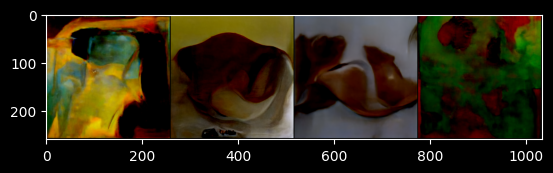

In [40]:
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

scheduler: DDIMScheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    x = scheduler.step(noised_pred, t, x).prev_sample

grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1))

In [39]:
torch.cuda.empty_cache()

In [7]:
def color_loss(images, target_color=(.1, .9, .5)):
    target = (torch.tensor(target_color).to(images.device) * 2 - 1)
    target = target[None, :, None, None]
    error = torch.abs(images - target).mean()
    return error

  0%|          | 0/40 [00:00<?, ?it/s]

Step 0, loss: 28.97610092163086
Step 10, loss: 11.256721496582031
Step 20, loss: 11.014945983886719
Step 30, loss: 11.15264892578125


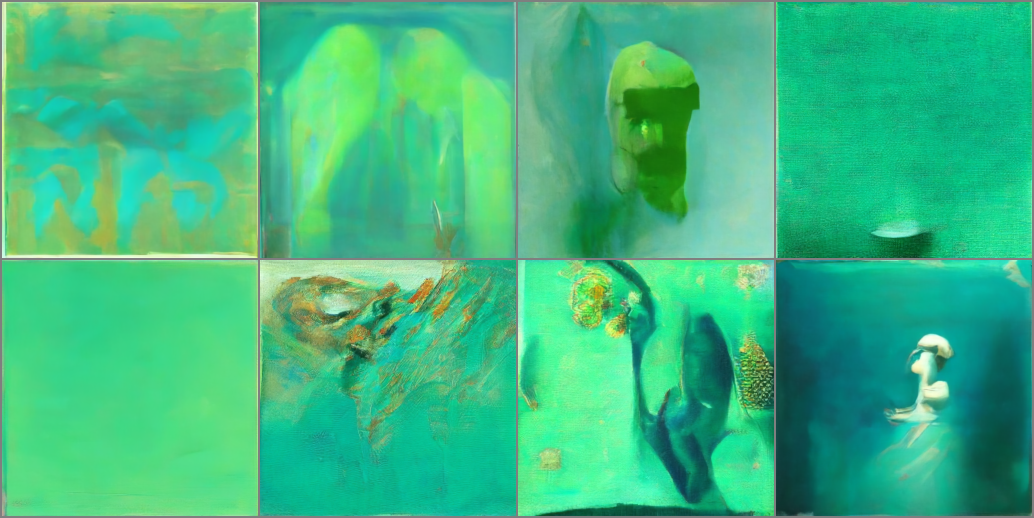

In [6]:
guidance_loss_scale = 40
x = torch.randn(8, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    x = x.detach().requires_grad_()
    x0 = scheduler.step(noised_pred, t, x).pred_original_sample
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(f"Step {i}, loss: {loss.item()}")
    cond_grad = - torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noised_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
Image.fromarray((im.numpy() * 255).astype(np.uint8))

  0%|          | 0/40 [00:00<?, ?it/s]

Step 0, loss: 30.930774688720703
Step 10, loss: 9.791643142700195
Step 20, loss: 7.611188888549805
Step 30, loss: 7.69845724105835


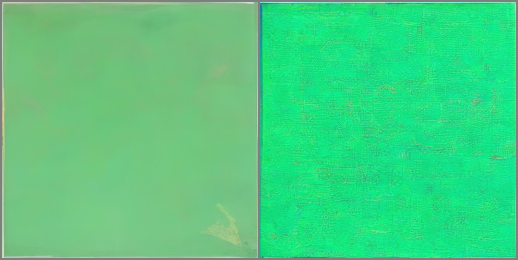

In [7]:
guidance_loss_scale = 40
x = torch.randn(2, 3, 256, 256).to(device)
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    x = x.detach().requires_grad_()
    model_input = scheduler.scale_model_input(x, t)
    noised_pred = image_pipe.unet(model_input, t)['sample']
    x0 = scheduler.step(noised_pred, t, x).pred_original_sample
    loss = color_loss(x0) * guidance_loss_scale
    if i % 10 == 0:
        print(f"Step {i}, loss: {loss.item()}")
    cond_grad = - torch.autograd.grad(loss, x)[0]
    x = x.detach() + cond_grad
    x = scheduler.step(noised_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
Image.fromarray((im * 255).detach().numpy().astype(np.uint8))

In [15]:
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms("ViT-B/32", pretrained="openai")
clip_model = clip_model.to(device)

tfms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomAffine(5),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711],
    ),
])

def clip_loss(image, text_features):
    image_features = clip_model.encode_image(tfms(image))
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    # great circle distance squared
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )
    return dists.mean()





In [16]:
prompt = "Red Rose (still life), red flower painting"
guidance_loss_scale = 8
n_cuts = 4

scheduler.set_timesteps(50)
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad():
    text_features1 = clip_model.encode_text(text)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features2 = clip_model.encode_text(text)
text_features1[0][0], text_features2[0][0]
text_features1[0][0].dtype, text_features2[0][0].dtype

c:\Users\Triton Neo 16\diffusion-teset\venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


(torch.float32, torch.float16)

  0%|          | 0/50 [00:00<?, ?it/s]

Step 0, loss: 7.536079406738281
Step 25, loss: 7.020721435546875


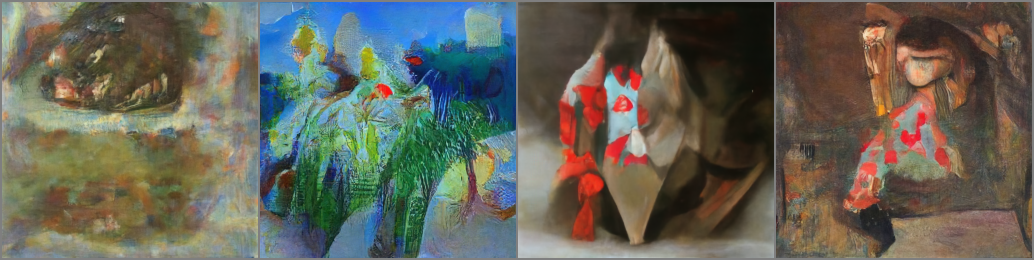

In [17]:
prompt = "Red Rose (still life), red flower painting"
guidance_loss_scale = 8
n_cuts = 4

scheduler.set_timesteps(50)
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)
x = torch.randn(4, 3, 256, 256).to(device)

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noised_pred = image_pipe.unet(model_input, t)['sample']
    cond_grad = 0
    for cut in range(n_cuts):
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noised_pred, t, x).pred_original_sample
        loss = clip_loss(x0, text_features) * guidance_loss_scale
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts
    if i % 25 == 0:
        print(f"Step {i}, loss: {loss.item()}")
    alpha_bar = scheduler.alphas_cumprod[i]
    x = x.detach() + cond_grad * alpha_bar.sqrt()
    x = scheduler.step(noised_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
Image.fromarray((im * 255).numpy().astype(np.uint8))


In [18]:
plt.plot([1 for a in scheduler.alphas_cumprod], label="no scaling")
plt.plot([a for a in scheduler.alphas_cumprod], label="alpha bar")
plt.plot([a.sqrt() for a in scheduler.alphas_cumprod], label="alpha bar sqrt()")
plt.plot([(1-a).sqrt() for a in scheduler.alphas_cumprod], label="1 - alpha bar sqrt()")
plt.legend()

In [19]:
%%capture
%pip install gradio

In [23]:
import gradio as gr
from PIL import Image, ImageColor

def generate(color, guidance_loss_scale):
    print(color, guidance_loss_scale)
    target_color = ImageColor.getcolor(color, "RGB")
    target_color = [a / 255 for a in target_color]
    x = torch.randn(1, 3, 256, 256).to(device)
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        model_input = scheduler.scale_model_input(x, t)
        with torch.no_grad():
            noised_pred = image_pipe.unet(model_input, t)['sample']
        x = x.detach().requires_grad_()
        x0 = scheduler.step(noised_pred, t, x).pred_original_sample
        loss = color_loss(x0, target_color) * guidance_loss_scale
        cond_grad = - torch.autograd.grad(loss, x)[0]
        x = x.detach() + cond_grad
        x = scheduler.step(noised_pred, t, x).prev_sample
    grid = torchvision.utils.make_grid(x, nrow=4)
    im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * .5 + .5
    im = Image.fromarray((im.numpy() * 255).astype(np.uint8))
    return im

inputs = [
    gr.ColorPicker(label = 'color',value="#55FFAA"),
    gr.Slider(minimum=0, maximum=30, value=3, label="Guidance Loss Scale"),
]
outputs = gr.Image(label="result")

demo = gr.Interface(
    fn=generate,
    inputs=inputs,
    outputs=outputs,
    examples=[
        ["#BB2266", 3],
        ["#44CCAA", 5],
    ])
demo.launch(debug=True)

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


#55FFAA 3


  0%|          | 0/50 [00:00<?, ?it/s]

#55FFAA 9.6


  0%|          | 0/50 [00:00<?, ?it/s]

#55FFAA 5.1


  0%|          | 0/50 [00:00<?, ?it/s]

#55FFAA 5.1


  0%|          | 0/50 [00:00<?, ?it/s]

#55FFAA 0.3


  0%|          | 0/50 [00:00<?, ?it/s]

#BB2266 3


  0%|          | 0/50 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.


In [9]:
%%capture
%pip install wheel
%pip install torchviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 KB 828.8 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [10]:
guidance_loss_scale = 40
x = torch.randn(8, 3, 256, 256).to(device)
t = 10
model_input = scheduler.scale_model_input(x, t)
with torch.no_grad():
    noised_pred = image_pipe.unet(model_input, t)['sample']
x = x.detach().requires_grad_() # clean x grad that generated by previous step
x0 = scheduler.step(noised_pred, t, x).pred_original_sample
loss = color_loss(x0) * guidance_loss_scale
cond_grad = - torch.autograd.grad(loss, x)[0]
x = x.detach() + cond_grad
x = scheduler.step(noised_pred, t, x).prev_sample

import torchviz
dot = torchviz.make_dot(cond_grad, params=dict(image_pipe.unet.named_parameters()))
dot.view()


'Digraph.gv.pdf'

/snap/core20/current/lib/x86_64-linux-gnu/libstdc++.so.6: version `GLIBCXX_3.4.29' not found (required by /lib/x86_64-linux-gnu/libproxy.so.1)
Failed to load module: /home/mix060514/snap/code/common/.cache/gio-modules/libgiolibproxy.so

(process:17519): Gtk-WARNING **: 15:44:34.301: Locale not supported by C library.
	Using the fallback 'C' locale.
/home/mix060514/snap/code/common/.cache/gio-modules/libgiolibproxy.so: cannot open shared object file: Permission denied
Failed to load module: /home/mix060514/snap/code/common/.cache/gio-modules/libgiolibproxy.so

(evince:17519): Gtk-WARNING **: 15:44:34.388: Theme parsing error: gtk-keys.css:1:0: Failed to import: Error opening file /snap/code/155/usr/share/themes/Default/gtk-3.0/gtk-keys.css: Permission denied
Gtk-Message: 15:44:34.389: Failed to load module "canberra-gtk-module"
Gtk-Message: 15:44:34.399: Failed to load module "canberra-gtk-module"


In [17]:
target_color=(.1, .9, .5)
target = (torch.tensor(target_color))
target = target[None, :, None, None]
# error = torch.abs(images - target).mean()
target_color
target, target.shape


(tensor([[[[0.1000]],
 
          [[0.9000]],
 
          [[0.5000]]]]),
 torch.Size([1, 3, 1, 1]))

In [18]:
target_color=(.1, .9, .5)
target = (torch.tensor(target_color))
target = target.unsqueeze(1)
# error = torch.abs(images - target).mean()
target_color
target, target.shape


(tensor([[0.1000],
         [0.9000],
         [0.5000]]),
 torch.Size([3, 1]))

In [19]:
target_color=(.1, .9, .5)
target = (torch.tensor(target_color))
target = target.reshape(1, 3, 1, 1)
# error = torch.abs(images - target).mean()
target_color
target, target.shape


(tensor([[[[0.1000]],
 
          [[0.9000]],
 
          [[0.5000]]]]),
 torch.Size([1, 3, 1, 1]))